In [ ]:
from google.colab import drive
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [ ]:
drive.mount('/drive') 

Mounted at /drive


In [ ]:
train_Les=np.load('/drive/My Drive/CAD_1_1/train_Les_Ordered.npz',allow_pickle=True)
train_NV=np.load('/drive/My Drive/CAD_1_1/train_NV_Ordered.npz',allow_pickle=True)
val_Les=np.load('/drive/My Drive/CAD_1_1/val_Les_Ordered.npz',allow_pickle=True)
val_NV=np.load('/drive/My Drive/CAD_1_1/val_NV_Ordered.npz',allow_pickle=True)
train_bcc = np.load('/drive/My Drive/CAD_1_2/train_bcc.npz',allow_pickle=True)


In [ ]:
trainX_Les  = np.array(train_Les['trainX_Les'])
trainX_NV   = np.array(train_NV['trainX_NV'])
valX_Les    = np.array(val_Les['valX_Les'])
valX_NV     = np.array(val_NV['valX_NV'])
trainX_bcc  = np.array(train_bcc['trainX_bcc'])

In [ ]:
print(trainX_Les.shape)
print(trainX_NV.shape)
print(valX_Les.shape)
print(valX_NV.shape)
print(trainX_bcc.shape)

(2400, 450, 600, 3)
(2400, 450, 600, 3)
(600, 450, 600, 3)
(600, 450, 600, 3)
(400, 450, 600, 3)


In [ ]:
def removeHair(img):
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(17,17)) #kernelsize=17x17
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)     
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    hairRemoved = cv2.inpaint(img,threshold,1,cv2.INPAINT_TELEA) 
    return hairRemoved

In [ ]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def seg(x,dir=0,counter=0):
  first=removeHair(cv2.cvtColor(x,cv2.COLOR_BGR2RGB))
  frame = increase_brightness(first, value=70)
  kernel = np.ones((13,13),np.float32)/169
  dst = cv2.filter2D(frame,-1,kernel)
  equ = cv2.equalizeHist(cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY))
  opening = cv2.morphologyEx(np.float32(cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20)))
  ret, thresh1 = cv2.threshold(np.uint8(opening), 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)            
  output = cv2.connectedComponentsWithStats(thresh1,cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  area = []
  for i in range(0, numLabels):
    if i == 0:
      pass
    else:
      area.append(stats[i, cv2.CC_STAT_AREA])
  index = area.index(max(area))
  result = (labels==index+1).astype("uint8")*255
  seg = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
  seg=255-seg
  seg =seg/255
  seg =np.uint8(seg)
  res = cv2.multiply(first,seg) 
  res= cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
  #cv2.imwrite(dir+'/'+str(counter)+'.jpg', res)
  #plt.imshow(res)
  return res

(-0.5, 599.5, 449.5, -0.5)

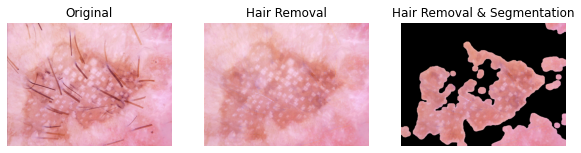

In [ ]:
img= trainX_Les[349]
plt.figure(figsize = (10,10))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(removeHair(img))
plt.title('Hair Removal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(seg(img))
plt.title('Hair Removal & Segmentation')
plt.axis('off')